<h1>Pre-work</h1>

On my laptop I can't run the code for the entire dataframe, so it's going to be on the half and we'll have to run it at the library over more powerful laptop. Unless one of us has a powerful enough laptop.
Other options:
- run on Google Cloud
- use Columbia's Cluster

In [1]:
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools

from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.data import load

#!pip install langdetect
from langdetect import detect

from math import ceil

from pandas import read_csv

from wordcloud import WordCloud, STOPWORDS

from datetime import datetime

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn import metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV

from os import path
from PIL import Image
from multiprocessing.dummy import Pool as ThreadPool 

from sklearn import datasets # toy datasets

start_time = datetime.now()

<h2>Processing functions</h2>

<h3>Normalization Function</h3>

<h4>Normalization over number of words

In [2]:
def normalization_word(var):
    """Returns number of words."""
    words = nltk.Text(word_tokenize(((var))))
    return len(words)

<h4>Normalization by number of Sentences</h4>

In [3]:
def normalization_sentence(var):
    """Returns number of sentences."""
    sentences = nltk.Text(sent_tokenize(var))
    return len(sentences)

<h4>Normalization by number of Characters</h4>


In [4]:
def normalization_character(var):
    """Returns number of characters."""
    return len(var)

<h3>Cleaning Function</h3>

In [5]:
def cleaning(var):
    """Take a string. Returns a string with only lowercase letters and the space between words."""
    plain_string = ""
    for x in var:
        x = x.lower()
        if (('a' <= x and x <= 'z') or x == ' '):
            plain_string += x
        elif x == '\'': # any apostrophes(') are replaced by a space 
            plain_string += ' '
    while '  ' in plain_string: # any multiple spaces are replaced by a single space
        plain_string = plain_string.replace('  ', ' ')
    return plain_string

<h3>Creation of the dataframes</h3>

In [6]:
train = pd.read_csv("train.csv")
# data must be in same folder

author_list = ['EAP', 'HPL', 'MWS']
train.text= train.text.astype(str) # casts the type of the text column to str
train.author = pd.Categorical(train.author)

train = train[0:300]  # size reduction for coding

train_back_up = train.copy() # back-up used to define future dataframes

In [7]:
# just a test cell
test = train['text'][0]
test

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

<h1>Word Clouds</h1>

In [8]:
# full text from the authors as an array
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

# full text from the authors as a string
eap_s = " ".join(eap)
hpl_s = " ".join(hpl)
mws_s = " ".join(mws)

# full PLAIN text (i.e. no capital and punctuation) from the authors as a string
eap_s_c = cleaning(eap_s)
hpl_s_c = cleaning(hpl_s)
mws_s_c = cleaning(mws_s)

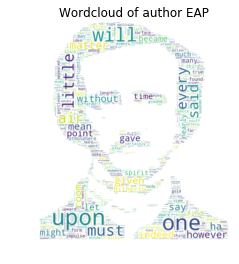

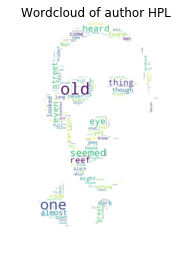

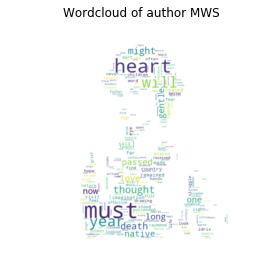

In [9]:
# Read the whole text
list_text = [eap_s_c, hpl_s_c, mws_s_c]

# read the mask image
# taken from http://www.stencilry.org/
eap_mask = np.array(Image.open("eap_mask.jpg"))
hpl_mask = np.array(Image.open("hpl_mask.jpg"))
mws_mask = np.array(Image.open("mws_mask.jpg"))
list_mask = [eap_mask, hpl_mask, mws_mask]

stopwords = set(STOPWORDS)

for i in range(3):
    wc = WordCloud(background_color="white", max_words=2000, mask=list_mask[i],
                   stopwords=stopwords)
    # generate word cloud
    wc.generate(list_text[i])
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Wordcloud of author ' + author_list[i])
    plt.axis("off")
    plt.figure()
    # store to file
    wc.to_file("{}_wordcloud.png".format(author_list[i]))
    
plt.show()

<h1>Splitting the training set.</h1>
<br>
Because we have only two dataset, one for training and the other for the Kaggle test. We need to split our 'Kaggle training' set (called t0) into training (called tr1) (in the sense of the training of our predictive model) and testing set (called ts1) (in the sense of testing our models, and not be tested by Kaggle !).<br>
<br>
We shall notice we will choose the best classifier only with the tr1 DataSet. Then, we will test this classifier with ts1 to see if we over-fitted over tr1.<br>
<br>

Once we havechosen the classifier and checked for over-fitting, we will train the chosen classifier over tr1 and ts1. We will use this to predict over the "Kaggle Test Dataset" and create our submission. 

In [10]:
t0 = train.copy()

In [11]:
tr1, ts1 = train_test_split(t0, test_size=20/80)
# 20% to tr1 and 80% to ts1

print(len(t0))
print(len(tr1))
print(len(ts1))
print(len(tr1) / len(t0))
print(len(ts1) / len(t0))
print((len(tr1) / len(t0)) + (len(ts1) / len(t0)))

300
225
75
0.75
0.25
1.0


In [12]:
tr1.head()

,id,text,author
66,id06312,"I dared, I conquered them all, till now I have...",MWS
77,id06377,The stranger learned about twenty words at the...,MWS
18,id14862,I even went so far as to speak of a slightly h...,EAP
253,id08978,"Xh, pxh, pxh, Jxhn, dxn't dx sx Yxu've gxt tx ...",EAP
267,id08711,"The remains of the half finished creature, who...",MWS


In [13]:
ts1.head()

,id,text,author
140,id12353,As I fled from that accursed castle along the ...,HPL
89,id10676,All that he said threw greatly into the shade ...,MWS
247,id12312,He made a vow against love and its train of st...,MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
51,id22197,"I still continued in the plane of the elipse, ...",EAP


<h1>Feature Engineering</h1>

<h2>Meta Features</h2>

<h3>Average sentence length (in characters)</h3>

In [14]:
def length_character(var):
    """Takes a string returns an int (average sentence length in characters)."""
    return len(var) / normalization_sentence(var)

<h3>Average sentence length (in words)</h3>

In [15]:
def length_sentence(var):
    """Takes a string and returns an int (average sentence length in words)."""
    return len(var.split()) / normalization_sentence(var)

<h3>Average characters per word</h3>

In [16]:
def length_word(var):
    """Takes a string and returns an int (average characters per word). Excludes punctuations."""
    return len(var.split()) / normalization_word(var)

<h3>Punctuation density</h3>
Now we take into consideration differences in punctuation.

In [17]:
def density_coma(var):
    """Takes a string and returns the ratio of punctuations to characters."""
    cpunc = 0
    for x in var:
        if x == ',':
            cpunc += 1
    return cpunc / normalization_character(var)

In [18]:
def density_point(var):
    """Takes a string and returns the ratio of periods(.) to characters."""
    cpunc = 0
    for x in var:
        if x == '.':
            cpunc += 1
    return cpunc / normalization_character(var)

In [19]:
def density_colon(var):
    """Takes a string and returns the ratio of colons(:) to characters."""
    cpunc = 0
    for x in var:
        if x == ':':
            cpunc += 1
    return cpunc / normalization_character(var)

In [20]:
def density_semicolon(var):
    """Takes a string and returns the ratio of semicolons(;) to characters."""
    cpunc = 0
    for x in var:
        if x == ';':
            cpunc += 1
    return cpunc / normalization_character(var)

In [21]:
def density_interro(var):
    """Takes a string and returns the ratio of question marks(?) to characters."""
    cpunc = 0
    for x in var:
        if x == '?':
            cpunc += 1
    return cpunc / normalization_character(var)

In [22]:
def density_expl(var):
    """Takes a string and returns the ratio of exclamation points(!) to characters."""
    cpunc = 0
    for x in var:
        if x == '!':
            cpunc += 1
    return cpunc / normalization_character(var)

<h3>Percentage of unique words per sentence</h3>

In [23]:
def vocabulary_sentence(var):
    """Takes a string and returns the ratio of different words to all words."""
    var = nltk.Text(sent_tokenize(var))
    vocabulary_list = []
    for c in var:
        if normalization_word(c) != 0:
            vacabulary_count_sentence = len({x.lower() for x in word_tokenize(cleaning(c))})
            vocabulary_list.append(vacabulary_count_sentence / normalization_word(c))
    return np.mean(vocabulary_list)

In [24]:
# just a test cell

vocabulary_sentence("Wow, this is a bad one. On Macs running the latest version of High Sierra (10.13.1 (17B48)), it appears that anyone can log in just by putting “root” in the user name field in a certain place. This is a huge, huge problem. Apple will fix it probably within hours but holy moly. Do not leave your Mac unattended")

0.79527972027972038

<h3>Stopword percentage</h3>

In [25]:
def density_stopword(var):
    """Takes a string and returns the ratio of stopwords to all words."""
    cs = 0
    for x in nltk.Text(word_tokenize(var)):
        if x in STOPWORDS:
            cs += 1
    return cs/normalization_word(var)

<h3>Noun Density</h3>

In [26]:
def density_noun(var):
    """Takes a string and returns the ratio of nouns to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'NN': # all noun tags start with NN
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Verb Density</h3>

In [27]:
def density_verb(var):
    """Takes a string and returns the ratio of verbs to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'VB': # all verb tags start with VB
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Adjective Density</h3>

In [28]:
def density_adjective(var):
    """Takes a string and returns the ratio of adjectives to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'JJ': # all adjective tags start with JJ
            l.append(x)
    return len(l) / normalization_word(var)

<h3>Adjective to noun ratio</h3>

In [29]:
def adjective_to_noun(var):
    """Takes a string and returns the ratio of adjectives to nouns."""
    return density_adjective(var) / (density_noun(var) + 0.5) # add 0.5 to avoid division by 0 error

<h3>Emphases on Words or Phrases</h3>

In [30]:
def count_emph(var):
    """Takes a string and returns the usage count of emphases using double quotes."""
    emph_trig_words = 'word called the a their my his her for that those like of words'.split() 
    emph_count = 0
    var = var.lower()
    for word in emph_trig_words:
        emph_count += var.count('{} "'.format(word))
    return emph_count

<h3>Dialogues Breaks</h3>

In [31]:
def count_dial_break(var):
    """
    Takes a string and returns the count of dialogue breaks used.
    Example of a dialogue break: ("D ," replied Dupin, "is a desperate man, and a man of nerve.)
    """
    return var.count(", \"")

<h3>Dialogues</h3>

In [32]:
def count_dblqt(var):
    """Takes a string and returns the count of sets of double quotes"""
    return ceil(var.count('"')/2) # ceil function rounds up

In [33]:
def count_dial(var):
    """
    Takes a string and returns the count of dialogues used. Assumption is that if in double quotes but not an
    emphasis, then it is a dialogue.
    """
    return count_dblqt(var) - count_emph(var) - count_dial_break(var)

In [34]:
def break_to_dial_ratio(var):
    """Take sa string and returns the ratio of dialogue breaks to dialogues."""
    if not count_dial(var):
        return 0
    return count_dial_break(var) / count_dial(var)

<h3>Feminine and Masculine Words</h3>

In [35]:
def count_fem(var):
    """Takes a string and returns the count of feminine words."""
    fem_words = 'she her woman herself girl women lady queen princess daughter madam madame wife'.split()
    fem_count = 0
    var = cleaning(var)
    for word in var.split():
        if word in fem_words:
            fem_count += 1
    return fem_count

In [36]:
def count_mas(var):
    """Takes a string and returns the count of masculine words."""
    mas_words = 'he his man mr himself boy men gentleman gentlemen king prince son sir husband'.split()
    mas_count = 0
    var = cleaning(var)
    for word in var.split():
        if word in mas_words:
            mas_count += 1
    return mas_count

In [37]:
def fem_to_mas_ratio(var):
    """Takes a string and returns the ratio of feminine words to masculine words."""
    fem_count = count_fem(var)
    mas_count = count_mas(var)
    if fem_count and not mas_count:
        fem_mas_ratio = 1
    elif not fem_count and not mas_count:
        fem_mas_ratio = 0
    else:
        fem_mas_ratio = fem_count / mas_count
    return fem_mas_ratio

In [38]:
df = pd.DataFrame([['EAP', eap_s], ['HPL', hpl_s], ['MWS', mws_s]])
df.columns = ['author', 'text']

for f in [count_emph, count_dial, count_dial_break, break_to_dial_ratio, count_fem, count_mas, fem_to_mas_ratio]:
    df['norm_' + f.__name__] = df.text.apply(f)
    
for f in [count_emph, count_dial, count_dial_break, count_fem, count_mas]: # normalization of count_emph, count_dial, and count_dial_break
    df['norm_' + f.__name__] = df['norm_' + f.__name__] / df.author.apply(lambda x: len(train[train.author == x]))
    
df

,author,text,norm_count_emph,norm_count_dial,norm_count_dial_break,norm_break_to_dial_ratio,norm_count_fem,norm_count_mas,norm_fem_to_mas_ratio
0,EAP,"This process, however, afforded me no means of...",0.026549,0.176991,0.035398,0.200000,0.079646,0.362832,0.219512
1,HPL,It never once occurred to me that the fumbling...,0.010309,0.041237,0.000000,0.000000,0.041237,0.783505,0.052632
2,MWS,How lovely is spring As we looked from Windsor...,0.000000,0.066667,0.055556,0.833333,0.488889,0.833333,0.586667


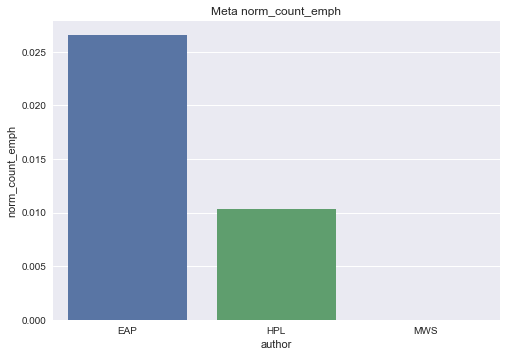

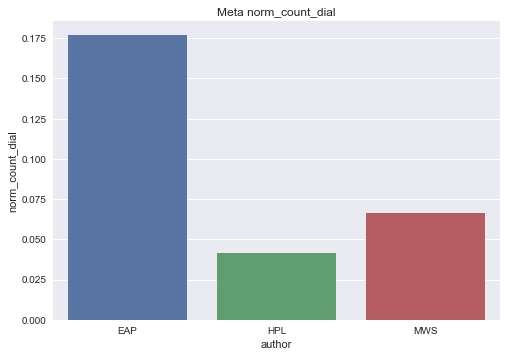

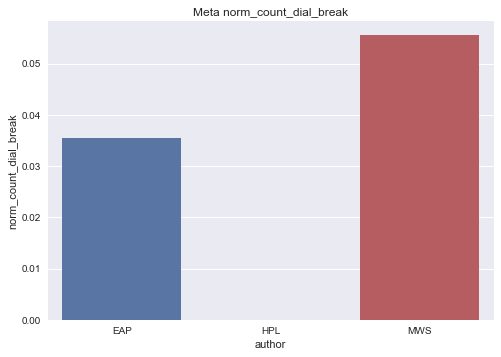

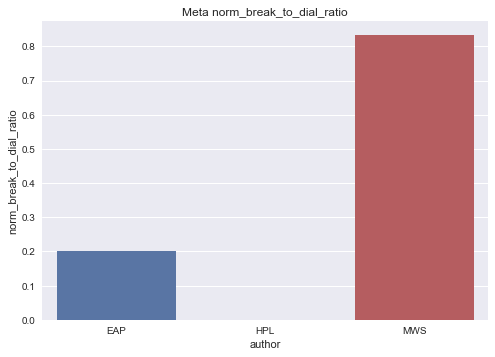

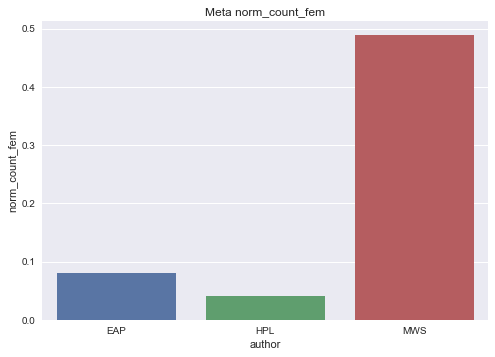

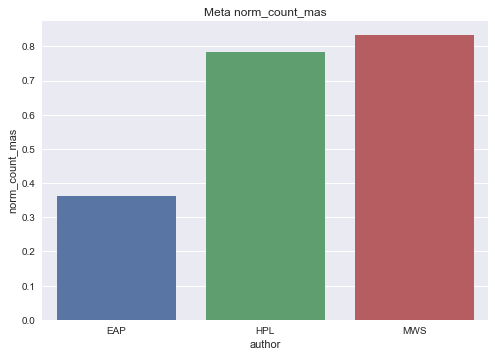

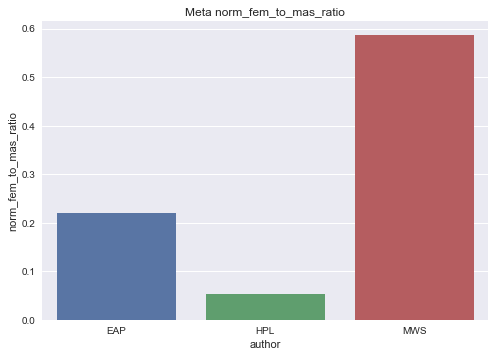

In [39]:
for c in df.columns[2:]:
    plt.style.use('seaborn')
    sns.barplot(x='author', y=c, data=df)
    plt.title('Meta {}'.format(c))
    plt.savefig('Meta {}'.format(c))
    plt.show()

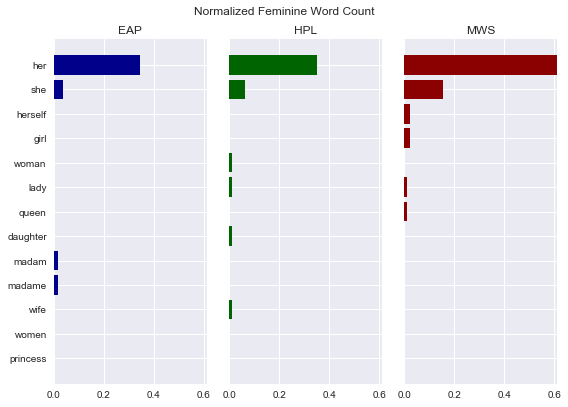

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fem_words = 'her she herself girl woman lady queen daughter madam madame wife women princess'.split()

plt.suptitle('Normalized Feminine Word Count', y=1.02)

xlmt = 0
for auth in [(eap_s_c, 'EAP'), (hpl_s_c, 'HPL'), (mws_s_c, 'MWS')]:
    for word in fem_words:
        norm_count = auth[0].count(word) / len(train[train.author == auth[1]])
        if norm_count > xlmt:
            xlmt = norm_count

for ax in ((ax1, eap_s_c, 'darkblue', 'EAP'), (ax2, hpl_s_c, 'darkgreen', 'HPL'), (ax3, mws_s_c, 'darkred', 'MWS')):
    y = np.arange(len(fem_words))
    x = [ax[1].count(word) / len(train[train.author == ax[3]]) for word in fem_words]
    ax[0].barh(y, x, align='center',
            color=ax[2], ecolor='black')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(fem_words)
    ax[0].invert_yaxis()
    ax[0].set_title(ax[3])
    ax[0].set_xlim([0, xlmt])
    
plt.tight_layout()
plt.savefig('Meta feminine word count')
plt.show()

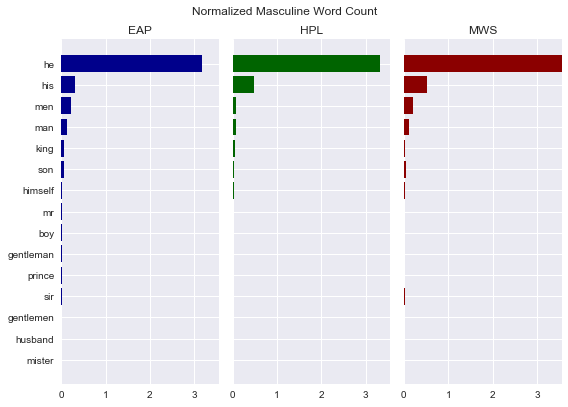

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
mas_words = 'he his men man king son himself mr boy gentleman prince sir gentlemen husband mister'.split()

plt.suptitle('Normalized Masculine Word Count', y=1.02)

xlmt = 0
for auth in [(eap_s_c, 'EAP'), (hpl_s_c, 'HPL'), (mws_s_c, 'MWS')]:
    for word in mas_words:
        norm_count = auth[0].count(word) / len(train[train.author == auth[1]])
        if norm_count > xlmt:
            xlmt = norm_count
            
for ax in ((ax1, eap_s_c, 'darkblue', 'EAP'), (ax2, hpl_s_c, 'darkgreen', 'HPL'), (ax3, mws_s_c, 'darkred', 'MWS')):
    y = np.arange(len(mas_words))
    x = [ax[1].count(word) / len(train[train.author == ax[3]]) for word in mas_words]
    ax[0].barh(y, x, align='center',
            color=ax[2], ecolor='black')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(mas_words)
    ax[0].invert_yaxis()
    ax[0].set_title(ax[3])
    ax[0].set_xlim([0, xlmt])
    
plt.tight_layout()
plt.savefig('Meta masculine word count')
plt.show()

<h3>Building of the Dataframe of Metadata</h3>

This is the list of all the meta data we are going to use to train our classifiers. We are also going to use bag of words. This could be modified if we add meta data.

In [42]:
def build_meta1(dataframe):
    """Builds a dataframe that shows the author and the first set of meta-data related to the sentence."""
    df_meta = dataframe.copy()
    for f in [count_emph, count_dial, count_dial_break, break_to_dial_ratio, count_fem, count_mas, fem_to_mas_ratio]:
        df_meta[f.__name__] = df_meta.text.apply(f)
    
    del df_meta['text']
    if 'author' in df_meta.columns:
        del df_meta['author']
    
    return df_meta

In [43]:
datameta1 = build_meta1(tr1)
datameta1

,id,count_emph,count_dial,count_dial_break,break_to_dial_ratio,count_fem,count_mas,fem_to_mas_ratio
66,id06312,0,1,0,0.0,5,0,1.0
77,id06377,0,0,0,0.0,0,0,0.0
18,id14862,0,0,0,0.0,0,0,0.0
253,id08978,0,0,0,0.0,0,0,0.0
267,id08711,0,0,0,0.0,0,0,0.0
96,id06172,0,0,0,0.0,1,0,1.0
261,id04561,0,1,0,0.0,0,0,0.0
211,id22514,0,0,0,0.0,1,2,0.5
158,id03570,0,0,0,0.0,0,0,0.0
84,id02647,0,1,0,0.0,0,0,0.0


In [44]:
def build_meta2(dataframe):
    """Builds a dataframe that shows the author and the other meta-data related to the sentence."""
    df_meta = dataframe.copy()
    list_meta = [length_character,
             length_sentence,
             length_word,  
             vocabulary_sentence,
             density_stopword,
             density_noun,
             density_verb,
             density_adjective,
             adjective_to_noun,
             density_coma,
             density_point,
             density_colon,
             density_semicolon,
             density_interro,
             density_expl
            ]
    for f in list_meta:
        df_meta[f.__name__] = df_meta.text.apply(f)
    return df_meta 

In [45]:
datameta2 = build_meta2(tr1)
datameta2

,id,text,author,length_character,length_sentence,length_word,vocabulary_sentence,density_stopword,density_noun,density_verb,density_adjective,adjective_to_noun,density_coma,density_point,density_colon,density_semicolon,density_interro,density_expl
66,id06312,"I dared, I conquered them all, till now I have...",MWS,454.0,88.0,0.880000,0.620000,0.390000,0.270000,0.120000,0.040000,0.051948,0.017621,0.002203,0.0,0.004405,0.0,0.0
77,id06377,The stranger learned about twenty words at the...,MWS,154.0,27.0,0.843750,0.750000,0.437500,0.187500,0.125000,0.062500,0.090909,0.019481,0.006494,0.0,0.006494,0.0,0.0
18,id14862,I even went so far as to speak of a slightly h...,EAP,270.0,48.0,0.872727,0.709091,0.418182,0.145455,0.127273,0.090909,0.140845,0.022222,0.003704,0.0,0.000000,0.0,0.0
253,id08978,"Xh, pxh, pxh, Jxhn, dxn't dx sx Yxu've gxt tx ...",EAP,129.0,28.0,0.682927,0.512195,0.073171,0.341463,0.121951,0.121951,0.144928,0.062016,0.007752,0.0,0.007752,0.0,0.0
267,id08711,"The remains of the half finished creature, who...",MWS,165.0,32.0,0.888889,0.694444,0.388889,0.166667,0.222222,0.055556,0.083333,0.018182,0.006061,0.0,0.000000,0.0,0.0
96,id06172,"I had expected some extravagant proposition, a...",MWS,147.0,22.0,0.880000,0.840000,0.280000,0.200000,0.160000,0.160000,0.228571,0.013605,0.006803,0.0,0.000000,0.0,0.0
261,id04561,"""Then up with you as soon as possible, for it ...",EAP,94.0,21.0,0.840000,0.760000,0.560000,0.000000,0.120000,0.080000,0.160000,0.010638,0.010638,0.0,0.000000,0.0,0.0
211,id22514,For a long time I dared not hope; but when his...,MWS,303.0,55.0,0.916667,0.716667,0.433333,0.183333,0.200000,0.066667,0.097561,0.009901,0.003300,0.0,0.003300,0.0,0.0
158,id03570,It is even possible that the train of my ideas...,MWS,111.0,22.0,0.956522,0.826087,0.478261,0.173913,0.173913,0.086957,0.129032,0.000000,0.009009,0.0,0.000000,0.0,0.0
84,id02647,"""That is absolutely needless,"" replied G .",EAP,42.0,7.0,0.700000,0.600000,0.100000,0.100000,0.200000,0.100000,0.166667,0.023810,0.023810,0.0,0.000000,0.0,0.0


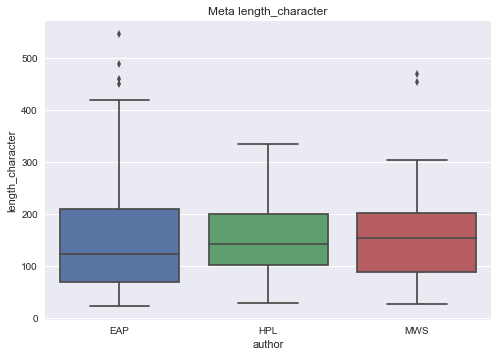

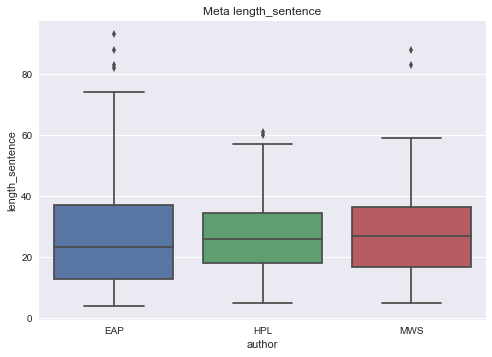

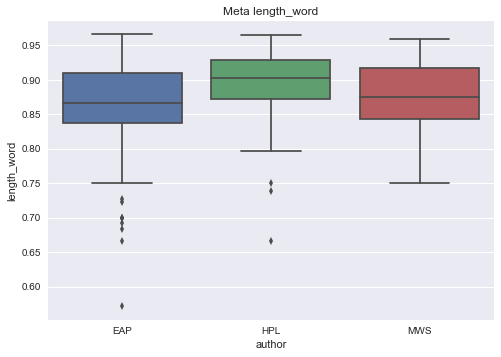

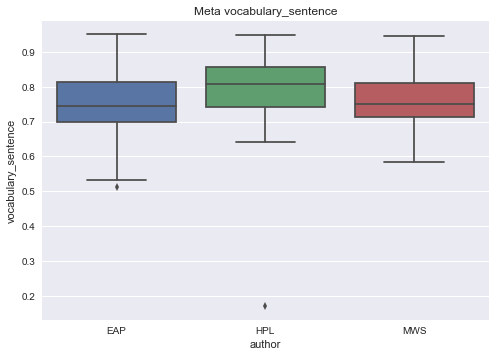

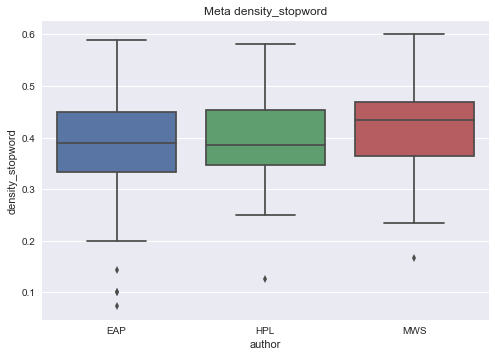

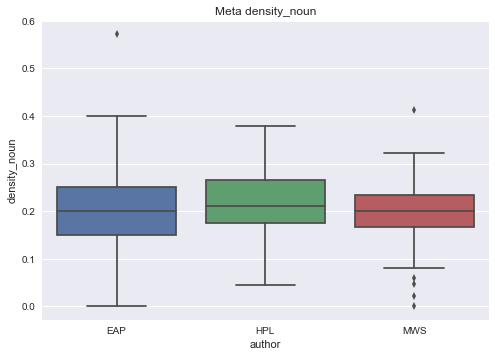

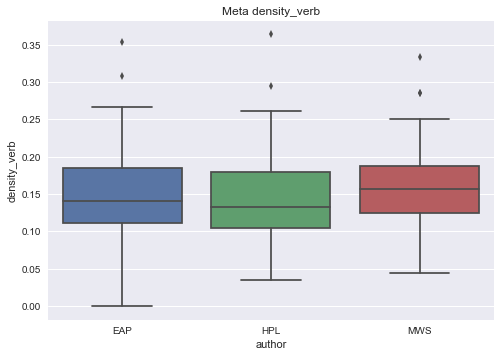

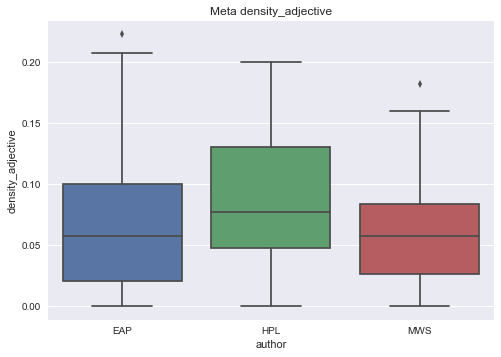

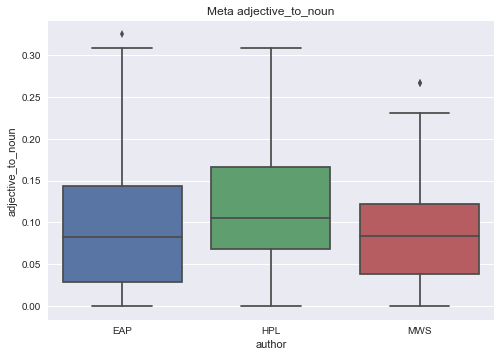

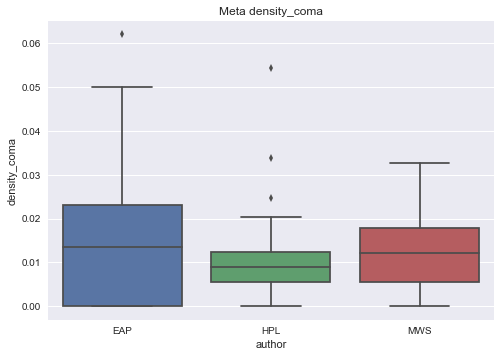

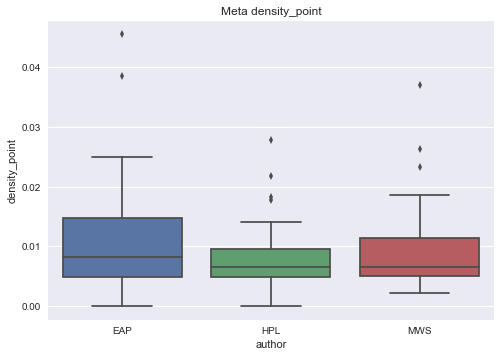

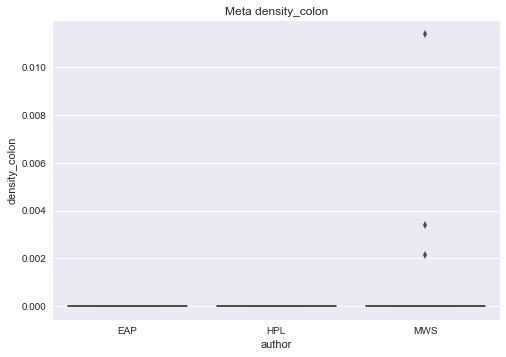

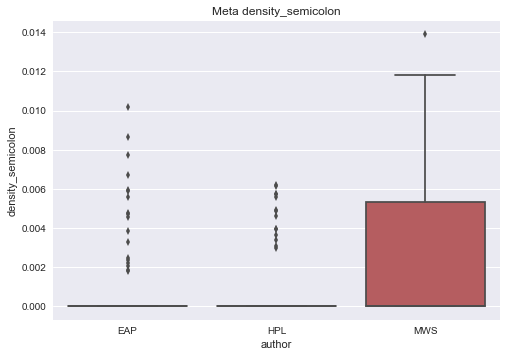

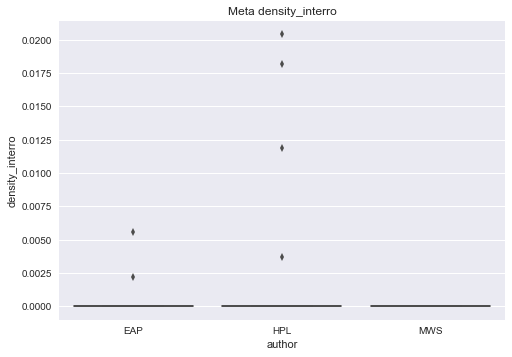

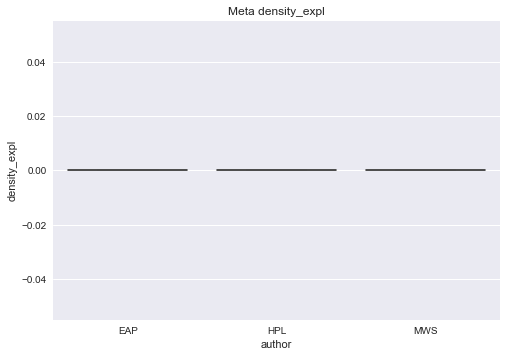

In [46]:
for c in datameta2.columns[3:]:
    plt.style.use('seaborn')
    sns.boxplot(x='author', y=c, data=datameta2)
    plt.title('Meta {}'.format(c))
    plt.savefig('Meta {}'.format(c))
    plt.show()

<h2>Text Features</h2>

<h3>First Word</h3>

In [47]:
def first_word_type(sents):
    """Takes a list of sentences and returns a list of the word type used to start each element."""
    res = list()
    for sent in sents:
        typ = nltk.pos_tag(sent.split())
        i = 0
        j = 0
        word = typ[i][0].lower()
        while i < len(sent.split()):
            if j < len(word) and word[j] >= 'a' and word[j] <= 'z':
                res.append(typ[i][1])
                break
            i += 1
    return res

In [ ]:
def first_word(dataframe):
    """Takes a dataframe and creates a column per word type with a value of 1 on the word type used."""
    df = dataframe.copy()
    elements = ['CC','CD','DT','EX','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNS','PDT','PRP','PRP$','RB','RBR','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WRB']
    for element in elements:
        column='first_word_'+element
        df[column]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        first_words = first_word_type(sents)
        for word in first_words:
            column = 'first_word_' + str(word)
            try:
                df[column].iloc[i] += 1
            except:
                pass
            
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [ ]:
datatext1 = first_word(tr1)
datatext1

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<h3>First Two Words</h3>

In [ ]:
def twofirst_words_type(sents):
    """Takes a list of sentences and returns a list of the 2 word types used to start each element."""
    res = list()
    for sent in sents:
        if len(sent.split()) > 1:
            typ = nltk.pos_tag(sent.split())
            res.append([typ[0][1],typ[1][1]])
    return res

In [ ]:
'''

def twofirst_word(dataframe):
    """Takes a dataframe and creates a column per word type pair with a value of 1 on the word type pair used."""
    df = dataframe.copy()
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        twofirst_words = twofirst_words_type(sents)
        for twoword in twofirst_words:
            column = 'first_two_' + str(twoword)
            try:
                df[column].iloc[i] += 1
            except:
                df[column] = 0
                df[column].iloc[i] = 1
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

'''


In [ ]:
#datatext2 = twofirst_word(tr1)
#datatext2

<h3>Last Word</h3>

In [ ]:
def last_word_type(sents):
    """Takes a list of sentences and returns a list of the word type used to end each element."""
    res= list()
    for sent in sents:
        typ = nltk.pos_tag(sent.split())
        i = 0
        j = 0
        word = typ[-i][0].lower()
        while i < len(sent.split()):
            if j < len(word) and word[j] >= 'a' and word[j] <= 'z':
                res.append(typ[-i][1])
                break
            i += 1
    return res

In [ ]:
def last_word(dataframe):
    """Takes a dataframe and creates a column per word type with a value of 1 on the word type used."""
    df = dataframe.copy()
    elements = ['FW','IN','JJ','NN','NNP','NNS','RB','RBS','RP','VB','VBD','VBN','VBP','VBZ']
    for element in elements:
        column='last_word_'+element
        df[column]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        last_words = last_word_type(sents)
        for word in last_words:
            column = 'last_word_' + str(word)
            try:
                df[column].iloc[i] += 1
            except:
                pass
            
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [ ]:
datatext3 = last_word(tr1)
datatext3

<h3>Last Two Words</h3>

In [ ]:
def twolast_words_type(sents):
    """Takes a list of sentences and returns a list of the word types used to end each element."""
    res = list()
    for sent in sents:
        if len(sent.split()) > 1:
            typ = nltk.pos_tag(sent.split())
            res.append([typ[-2][1], typ[-1][1]])
    return res

In [ ]:
'''
def twolast_word(dataframe):
    """Takes a dataframe and creates a column per word type pair with a value of 1 on the word type pairs used."""
    df=dataframe.copy()
    for i in range(len(df)):
        sents=nltk.Text(sent_tokenize(df['text'].iloc[i]))
        twolast_words = twolast_words_type(sents)
        for twoword in twolast_words:
            column='last_two_' + str(twoword)
            try:
                df[column].iloc[i]=df[column].iloc[i]+1
            except:
                df[column]=0
                df[column].iloc[i]=1
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df
'''


In [ ]:
#datatext4 = twolast_word(tr1)
#datatext4

<h1> Foreign Languages </h1>

In [ ]:
def language_sent(sents):
    """Takes a list of sentences and returns a list of the languages detected for each sentence."""
    res = list()
    for sent in sents:
        try:
            res.append(detect(sent))
        except:
            pass        
    return res

In [ ]:
def language(dataframe):
    """Takes a dataframe and creates a column per language with a value of 1 on the languages used."""
    df = dataframe.copy()
    languages=['af','ca','cy','da','de','es','et','fi','fr','hu','ind','it','nl','no','pl','pt','ro','sk','sl','so','sv','tl','tr','vi']
    for language in languages:
        df[language]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        n = len(sents)
        languages = language_sent(sents)
        for language in languages:
            if language != 'id':
                column = language
                try:
                    df[column].iloc[i] = df[column].iloc[i] + 1 / n
                except:
                    pass
            else:
                column='ind'
                try:
                    df[column].iloc[i] = df[column].iloc[i] + 1 / n
                except:
                    pass
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [ ]:
datatext5 = language(tr1)
datatext5

<h1> Emotions </h1>

The following function needs to have the file "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt" in the same folder.
Based on NRC data: 8 emotions

In [ ]:
def get_nrc_data():
    """Builds an emotion dictionary from the NRC emotion lexicon."""
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count = 0
    emotion_dict = dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count += 1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [ ]:
def emotions(dataframe):
    """Takes a dataframe and creates a column per emotion with a count on the emotions used."""
    df = dataframe.copy()
    emotions=['positive','anger','disgust','fear','negative','sadness','anticipation','joy','surprise','trust']
    for emotion in emotions:
        df[emotion]=0
    
    
    emotion_dic = get_nrc_data()
    for i in range(len(df)):
        words = df['text'].iloc[i].split()
        n = len(words)
        for word in words:
            if word in emotion_dic:
                for emotion in emotion_dic[word]:
                    column = emotion
                    try:
                        df[column].iloc[i] = df[column].iloc[i] + 1 / n
                    except:
                        pass
                    
    del df['text']
    if 'author' in df.columns:
        del df['author']
    
    return df

In [ ]:
datatext6 = emotions(tr1)
datatext6

<h3>Counting of words (a.k.a bag of words)</h3>

Instead of word/ n-grams frequencies, we are going to use tf_idf.

Some information about tf_idf: https://buhrmann.github.io/tfidf-analysis.html

Here, we don't detail for each N. Instead, we'll run the tf_idf for all the n-grams possible and the we'll take the best features. Our aim is to reduce the size/dimensions of our dataset's features.

In [ ]:
def transform_tag(var):
    """Transforms a string to a string of pos_tag"""
    inpt = nltk.pos_tag(word_tokenize(var))
    unzipped = zip(*inpt )
    return ' '.join([*list(unzipped)[1]])

<h4>Generation of the tf_idf counting dataFrame</h4>

In [ ]:
def counting_a(a, analysis):
    """
    Generates the tf-idf counting dataframe. First argument is the n of n-gram. Analysis type is 'word', 'char',
    token_pos', etc.
    """
    df_train = tr1.copy()
    df_test  = ts1.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'])
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'].apply(transform_tag))

        
    #this is the DataFrame Concerning the regular counting of words
    
    ##from regular counting to tf idf transformation coefficient

    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
    
    return (messages_tfidf, names, messages_tfidf_test)

In [ ]:
#mat_word, name_word, mat_word_test = counting_a(2,'word')
mat_word, name_word, mat_word_test = counting_a(2,'word')

print ('Shape of Sparse Matrix: ', mat_word.shape)
print ('Amount of Non-Zero occurences: ', mat_word.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word.nnz /
                             (mat_word.shape[0] * mat_word.shape[1])))
       
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_word_test.shape)
print ('Amount of Non-Zero occurences: ', mat_word_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word_test.nnz /
                             (mat_word_test.shape[0] * mat_word_test.shape[1])))
                             

As we can see, we get a matrix with <u>roughly a thousand </u>of  features. It's really heavy and we get a sparse matrix. Our goal is now to reduce the size of this matrix by getting the TOP-N features issued from the tf_idf.<br>
<br>
And we can create so both the matrix of training set. On which the TF_IDF is trained. <br>
And the matrix test, which is created with no-fit on it.

<h4>Reduction of the number of features to N</h4>

The next cell will be called in all the bag of words parts.

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    """Gets top n tf-idf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [ ]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    """Returns the top n tf-df features in a specific document (i.e. matrix row)"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    """
    Returns the top n features that on average are most important amongst documents in rows.
    Indentified by indices in grp_ids.
    """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    """
    Return a list of dfs, where each df holds top_n features and their mean tfidf value.
    Calculated across documents with the same class label.
    """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
def plot_tfidf_classfeats_h(dfs, name = 'default'):
    """Plot the data frames returned by the function plot_tfidf_classfeats()."""
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    #this line is for saving as picture
    plt.savefig(name)
    #this line is for showing
    plt.show()

<h4>Dimensionality reduction for bag of words (example for 2-grams)</h4>
We reduce by taking the TOP-N per author

In [ ]:
alpha_word = top_feats_by_class(mat_word, tr1.author, name_word)

In [ ]:
plot_tfidf_classfeats_h(alpha_word, 'bi_gram_word')

<h3>Building of bag of word and feature vectors</h3>

In [ ]:
# counting_a(1,'word')

In [ ]:
def build_bag_a(a, analysis, top_n = 50):
    df_bag = tr1.copy()
    df_bag_test = ts1.copy()
    
    build = counting_a(a, analysis)
    
    alpha = top_feats_by_class(build[0], df_bag.author, build[1], top_n = top_n)

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)


    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
    df_bag = df_bag.drop(labels = ['text','author'], axis = 1)
    df_bag_test = df_bag_test.drop(labels = ['text','author'], axis = 1)

        
    return df_bag, df_bag_test

In [ ]:
#build_bag_a(4, 'token_pos')[0].shape

In [ ]:
#build_bag_a(2, 'word')[0].head()

In [ ]:
#build_bag_a(2, 'token_pos')[0]

In [ ]:
#print(set(list(build_bag_a(2, 'word')[1]))-set(list(build_bag_a(2, 'word')[0])))

So, we get the top N-grams of words. Our problem is the depedency on the topic. We need to produce other features which are less dependant on the topic. There are sereveral possibility. Let's detail: <br>
- Stemming<br>
- Character Counting<br>
- Pos_tagging

<h2>Counting of Character (a.k.a bag of character)</h2>

Here, we count the use of some caracter, and n-grams of caracter.

<h3>Generation of the tf-idf counting dataFrame</h3>

In [ ]:
mat_char, name_char, mat_char_test = counting_a(3, 'char')

print ('Shape of Sparse Matrix: ', mat_char.shape)
print ('Amount of Non-Zero occurences: ', mat_char.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char.nnz /
                             (mat_char.shape[0] * mat_char.shape[1])))
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_char_test.shape)
print ('Amount of Non-Zero occurences: ', mat_char_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char_test.nnz /
                             (mat_char_test.shape[0] * mat_char_test.shape[1])))

<h3>Dimensionnality reduction for bag of characters example for 3 gram</h3>
We reduce by taking the TOP-N per author

In [ ]:
alpha_char = top_feats_by_class( mat_char, tr1.author, name_char)

In [ ]:
plot_tfidf_classfeats_h(alpha_char, 'tr_gram_char')

<h3>Building of bag of character and feature vectors</h3>

In [ ]:
#build_bag_a(3, 'char')[0].shape

<h2>Counting of POS Tag (a.k.a bag of Tag)</h2>

Here, we count the use of some caracter, and n-grams of caracter.<br>
So we have, some non-topic sensitive features.<br>
But we can produce an other type of feature based on the POS_tagging.

POS tag features. 

We will check the occurence of the elements from the Upenn Tagset. <br>

In [ ]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
#list of all the possible tag names
print("|\\".join(list(tagdict)))

#this is the list of the different tokens we will use.
len(tagdict)

<h3>Generation of the tf-idf counting dataFrame</h3>
We had to adapt the arguments passed in the CountVectorizer.

In [ ]:
mat_pos, name_pos, mat_pos_test = counting_a(4, 'token_pos')

print ('Shape of Sparse Matrix: ', mat_pos.shape)
print ('Amount of Non-Zero occurences: ', mat_pos.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos.nnz /
                             (mat_pos.shape[0] * mat_pos.shape[1])))

print ('Shape of Sparse Test Matrix: ', mat_pos_test.shape)
print ('Amount of Non-Zero occurences: ', mat_pos_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos_test.nnz /
                             (mat_pos_test.shape[0] * mat_pos_test.shape[1])))

<h3>Dimensionnality reduction for bag of tags Example for 2 grams</h3>
We reduce by taking the TOP-N per author

In [ ]:
alpha_pos = top_feats_by_class(mat_pos, tr1.author, name_pos, top_n = 10)

In [ ]:
plot_tfidf_classfeats_h(alpha_pos, "four_gram_tag_pos")

<h3>Building of bag of tag and feature vectors</h3>

In [ ]:
#build_bag_a(2,'token_pos')[0].head()

<h2>Positivity/Negativity</h2>

<h4>Weighted sentiment analysis using Vader</h4>
Vader contains a list of 7500 features weighted by how positive or negative they are</h4>
<br>It uses these features to calculate stats on how positive, negative and neutral a passage is<br>
<br>And combines these results to give a compound sentiment (higher = more positive) for the passage<br>
<br>Human trained on twitter data and generally considered good for informal communication<br>
<br>10 humans rated each feature in each tweet in context from -4 to +4</h4>
<br>Calculates the sentiment in a sentence using word order analysis</h4>
<br>"marginally good" will get a lower positive score than "extremely good"
<br>Computes a "compound" score based on heuristics (between -1 and +1)</h4>
<br>Includes sentiment of emoticons, punctuation, and other 'social media' lexicon elements<br>

In [ ]:
def vader_comparison(texts):
    headers = ['pos','neg','neu','compound']
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(texts)
    pos = compound = neu = neg = 0
    num_sentences = len(sentences)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos += vs['pos'] / num_sentences
        compound += vs['compound'] / num_sentences
        neu += vs['neu'] / num_sentences
        neg += vs['neg'] / num_sentences
    return pos, neg, neu, compound

def density_positive(var):
    return vader_comparison(var)[0]

def density_negative(var):
    return vader_comparison(var)[1]

def density_neutral(var):
    return vader_comparison(var)[2]

def density_compound(var):
    return vader_comparison(var)[3]

In [ ]:
def build_sensi(dataframe):
    df_sen = dataframe.copy() #change here to make sense
    
    df_sen[density_positive.__name__] = df_sen.text.apply(density_positive)
    df_sen[density_negative.__name__] = df_sen.text.apply(density_negative)
    df_sen[density_neutral.__name__] = df_sen.text.apply(density_neutral)
    df_sen[density_compound.__name__] = df_sen.text.apply(density_compound)
    
    del df_sen['text']
    if 'author' in df_sen.columns:
        del df_sen['author']
    return df_sen

#build_sensi(ts1).shape

In [ ]:
datatext7 = build_sensi(tr1)
datatext7

In [ ]:
#see returns an error because referenced function used by datatext7 dropped the 'author' column

# for c in datatext7.columns[3:]:
#     plt.style.use('seaborn')
#     sns.boxplot(x = 'author', y = c, data = datatext7)
#     plt.title('Sensi {}'.format(c))
#     plt.savefig('Sensi {}'.format(c))
#     plt.show()

<h2>Fusion of the bunch of features.</h2>

In [ ]:
#we build here the 2 feature datasets (one for TR1, one for TS1)
#should be adapted when we'll add features

def build_bunch_tr1(dataframe):
    list_df_tr = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a(1, 'word')[0],
                  build_bag_a(2, 'word')[0],
                  build_bag_a(3, 'word')[0],
                  build_bag_a(1, 'char')[0],
                  build_bag_a(2, 'char')[0],
                  build_bag_a(3, 'char')[0],
                  build_bag_a(4, 'char')[0],
                  build_bag_a(5, 'char')[0],
                  build_bag_a(6, 'char')[0],
                  build_bag_a(7, 'char')[0],
                  build_bag_a(1, 'token_pos')[0],
                  build_bag_a(2, 'token_pos')[0],
                  build_bag_a(3, 'token_pos')[0],
                  build_bag_a(4, 'token_pos')[0],
                  build_bag_a(5, 'token_pos')[0],
                  build_bag_a(6, 'token_pos')[0],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
              ]
    bunch = pd.merge(list_df_tr[0], list_df_tr[1])
    
    for i in range(2, len(list_df_tr)):
        alpha = bunch
        bunch = pd.merge(alpha, list_df_tr[i], on = 'id')
    
    return bunch

#df_feat_tr1 = build_bunch_tr1(tr1)

In [ ]:
def build_bunch_ts1(dataframe):
    list_df_ts = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a(1,'word')[1],
                  build_bag_a(2,'word')[1],
                  build_bag_a(3,'word')[1],
               
                  build_bag_a(1,'char')[1],
                  build_bag_a(2,'char')[1],
                  build_bag_a(3,'char')[1],
                  build_bag_a(4,'char')[1],
                  build_bag_a(5,'char')[1],
                  build_bag_a(6,'char')[1],
                  build_bag_a(7,'char')[1],
               
                  build_bag_a(1, 'token_pos')[1],
                  build_bag_a(2, 'token_pos')[1],
                  build_bag_a(3, 'token_pos')[1],
                  build_bag_a(4, 'token_pos')[1],
                  build_bag_a(5, 'token_pos')[1],
                  build_bag_a(6, 'token_pos')[1],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
                 ]

    bunch = pd.merge(list_df_ts[0], list_df_ts[1])
    
    for i in range(2, len(list_df_ts)):
        print(bunch.shape)
        bunch = pd.merge(bunch, list_df_ts[i], on = 'id')
    
    return bunch
df_feat_ts1 = build_bunch_ts1(ts1)

In [ ]:
# print ('Shape of df_feat_tr1 Matrix: ', df_feat_tr1.shape)
# print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_tr1.values))
# print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_tr1.values) /
#                                  (df_feat_tr1.shape[0] * df_feat_tr1.shape[1])))
# print('')

# print ('Shape of df_feat_ts1 Matrix: ', df_feat_ts1.shape)
# print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_ts1.values))
# print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_ts1.values) /
#                                  (df_feat_ts1.shape[0] * df_feat_ts1.shape[1])))

<h2>Quantitative parameters transformation</h2>
Quantitative parameters were transferred into a numerical vector with min-max normalization
from 0 to 1. <br>
<br>
It is necessary to have normalized vectors before training our dataset to avoid a disequilibrium among the coefficients.

http://blog.josephmisiti.com/help-commands-for-doing-machine-learning-in-python

In [ ]:
def build_normalization(df):
    result = df.copy()
    for feature_name in list(df)[3:]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value != min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
#build_normalization(df_feat_ts1).head()

#df_feat_ts1

So now, we have the normalized features matrix. 

<h1>Prediction: Selection of best set of feature selection technique and prediction model </h1>

<h2>Load and prepare data</h2>

In [ ]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_tr1(tr1))
dataframe_train.to_csv('dataframe_train')
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]

names = author_list
dataframe_test = build_normalization(build_bunch_ts1(ts1))
dataframe_test.to_csv('dataframe_test')
array = dataframe_test.values
X_test = array[:,3:]
Y_test = array[:,2]

In [ ]:
print(np.shape(X_train))
print(np.shape(X_test))

<h2>Feature Selection</h2><br>
See:http://scikit-learn.org/stable/modules/feature_selection.html <br><br>
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.<br>
<br>
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.<br>
<br>
Three benefits of performing feature selection before modeling your data are:<br>
<br>
- <b>Reduces Overfitting:</b> Less redundant data means less opportunity to make decisions based on noise.<br>
    <br>
- <b>Improves Accuracy:</b> Less misleading data means modeling accuracy improves.<br>
    <br>
- <b>Reduces Training Time:</b> Less data means that algorithms train faster.
<br><br>I will not follow the paper here but rather I'll follow the following website: <br>

https://machinelearningmastery.com/feature-selection-machine-learning-python/ <br>
see also: https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

So, here we will try a bunch of different methods:<br>
- Univariate feature selection
- Recursive feature elimination
- L1-based feature selection
- Tree-based feature selection


<h3>Number of selected features</h3>

<h4>Current number of features</h4>

In [ ]:
print('We have ' + str(np.shape(X_train)[1]) + ' features in total.')

<h4>Reduction of  number of feaures</h4>
The common possibilities are 10,20, quarter and half of total number of samples. <br>
<br>
For now, we only explore with quarter, tbd for the others.

In [ ]:
list_N = [10, 20, int(np.shape(X_train)[1]/4), int(np.shape(X_train)[1]/2)]

print('We want to test our models with ' + str(list_N) + ' features extracted from the ' + str(np.shape(X_train)[1]) + ' previous features')

<h3>Univariate feature selection</h3>

In [ ]:
def sel_univ(N):
    return SelectKBest(chi2, k=N)

<h3>Recursive feature elimination</h3>

In [ ]:
def sel_rec(N):
    model_rec = LogisticRegression()
    return RFE(model_rec, N)

<h3>Principal Component Analysis</h3>


In [ ]:
def sel_pca(N):
    return PCA(n_components=N)

<h3>Summary</h3>

In [ ]:
def build_selec(N):
    selectioners = []  
    selectioners.append(('S_UNIV_{}'.format(N), sel_univ(N)))
    selectioners.append(('S_REC_{}'.format(N), sel_rec(N)))
    selectioners.append(('S_PCA_{}'.format(N), sel_pca(N)))
    return selectioners

<h2>Predictive Models</h2><br>
So here we will try this bunch of feature models:

- LogisticRegression
- LinearDiscriminantAnalysis
- KNeighborsClassifier
- DecisionTreeClassifier
- GaussianNB
- SVC
- GradientBoostingClassifier
- AdaBoostClassifier
- ExtraTreesClassifier
- RandomForestClassifier


In [ ]:
def build_models(N):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM', SVC()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('MultiNB', MultinomialNB(alpha=0.03)))
    models.append(('Calibrated MultiNB', CalibratedClassifierCV( MultinomialNB(alpha=0.03), method='isotonic')))
    models.append(('Calibrated BernoulliNB', CalibratedClassifierCV( BernoulliNB(alpha=0.03), method='isotonic')))
    models.append(('Calibrated Huber', CalibratedClassifierCV(SGDClassifier(loss='modified_huber', alpha=1e-4, max_iter=10000, tol=1e-4), method='sigmoid')))
    return models

<h2>Pipeline</h2><br>

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves two purposes here:<br>
- Convenience and Encapsulation<br>
        You only have to call fit and predict once on your data to fit a whole sequence of estimators.
- Joint parameter selection<br>
        You can grid search over parameters of all estimators in the pipeline at once.
- Safety<br>
        Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [ ]:
def build_pipes(N):
    pipes = []
    for sel in build_selec(N):
        for mod in build_models(N):
            pipes.append([sel, mod])
    return pipes

<h2>Compare set of selection and predictive models</h2>
<br>


Here, we do ten times :<br>
- First we train over 9/10 of the training set (TR1)
- We test over the 1/10 remaining of the training set (TR1)<br>
<br>
But here we have a problem. Actually, the metric we need to mesure the models is 'neg_log_loss', because it is the one used by Kaggle. But it doesn't work and we don't know why. So, the metric used is accuracy. <br>
<br>
Then, we will take the 10 best models:<br>
- We train over the whole train set(TR1)
- We test over the whole test set (TS1)
- we mesure the best with the neg_log_loss metric (here it's working)<br>
Here the goal is to select the best with the Kaggle metric, but also we want to check if there is or not overfitting. 

In [ ]:
def eval_N(n):
    print('Go N')
    
    pipes = build_pipes(n)
    
    # evaluate each model in turn
    results = []
    names_model = []
    results_mean_var = []
    results_plot = []
    seed = 7
    count = 0

    for feat, model in pipes:
        intermediate_time = datetime.now()
        count +=1
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        pipeline = Pipeline([feat, model])
        #scorer = make_scorer((metrics.log_loss), labels = [0, 1 , 2])
        scorer = 'neg_log_loss'
        cv_results = model_selection.cross_val_score(pipeline,
                                                     X_train,
                                                     Y_train,
                                                     cv=kfold,
                                                     scoring = scorer)
        results.append(cv_results)
        results_mean_var.append((feat[0] + ' ' + model[0], cv_results.mean(), cv_results.var()))
        results_plot.append(cv_results)
        names_model.append(feat[0] + ' ' + model[0])
        msg = "%s: Mean=%f Stand Dev=(%f)" % ('Selector: ' + feat[0] + ' Predictive model: ' + model[0], cv_results.mean(), cv_results.std())
        print(msg)
        print('Running time: {}'.format(datetime.now() - start_time()))
        print('Intermediate time: {}'.format(datetime.now() - intermediate_time))


    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison when N = {}'.format(n))
    ax = fig.add_subplot(111)
    plt.boxplot(results_plot)
    ax.set_xticklabels(names_model, rotation='vertical')
    plt.show()
    results_plot = []
        
    return (results, results_mean_var)

In [ ]:
eval_N(10)

In [ ]:
pool = ThreadPool() 
training_results = pool.map(eval_N, list_N)
# x = pool.map_async( eval_N, list_N[0:2] )
pool.close()
pool.join()

<h2>Selection of selection and predictive models</h2>
<br> We take the three best estimators in mean. These will be tested other the 'TS1' test dataset. <br>
Really not sure about me for the criterion. Because, the variance is important too. We should think about it. 

In [ ]:
def get_and_select_results_mean_var():
    list_res = [] #total list of results
    selection = [] #top ten in term of average 
                   #subject to be in the criterion in term of mean
    criterion = 0.05 #we reject if the mean is greater than 5%
    
    
    for i in range(len(training_results)):
        list_res.extend(training_results[i][1])
        
    list_res.sort(key=lambda tup: tup[1], reverse = True)
    
    count = 0
    
    while len(selection)< min(10, len(list_res)):
        if list_res[count][2] <= criterion:
            selection.append(list_res[count][0])
            count +=1
    
    return selection

selected_feat_model = get_and_select_results_mean_var()

selected_feat_model    

<h1>Testing over the Testing dataset</h1> <br>
Now, we have to test the top-10 models over the remaining training set. Our aim is to see how are they are behaviouring over an un-known dataset and select the best. We will also, and it's the most import ensure there is no overfitting. 

<h2>List of selected</h2>

In [ ]:
best_pipes = []

for j in range(len(selected_feat_model)):
    for n in list_N:    
        for i in range(len(build_pipes(n))):
            f = build_pipes(n)[i][0][0] + ' ' + build_pipes(n)[i][1][0]
            if f == selected_feat_model[j]:
                best_pipes.append((f, build_pipes(n)[i]))
print(len(best_pipes))         

<h2>Confusion Matrix</h2>

In [ ]:
# import some data to play with

class_names = author_list




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [ ]:

def final_plot_confusion(Y_test, Y_pred):

    cm = confusion_matrix(Y_test, Y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

<h2>Test over Top Pipeline</h2>

In [ ]:
log_loss_list = []
for i in range(len(best_pipes)):
    name = best_pipes[i][0]
    pipeline = Pipeline([best_pipes[i][1][0], best_pipes[i][1][1]])
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    y_prob_output = pipeline.predict_proba(X_test) #this is what we send to kaggle.
    result = log_loss(Y_test, y_prob_output)
    log_loss_list.append((name, result, pipeline))

    
log_loss_list.sort(key=lambda tup: tup[1], reverse = False)
log_loss_list

In [ ]:
winner = log_loss_list[0]
print('The best combination Number, Processing, Model is ' 
      + winner[0]
     + ' with a log_loss score of '
     + str(winner[1]))

<h2>Confusion Matrix</h2>

In [ ]:
pipeline = winner[2]
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)  
final_plot_confusion(Y_test, Y_pred)  

<h2>Submission to Kaggle</h2>
First, we must adapt the features building functions.

<h3>Loading Test Set</h3>

In [ ]:
#loading of test dataset
test = pd.read_csv("test.csv")

test.text= test.text.astype(str)

test = test[0:30] #for coding 
#construction of the feature vectors

In [ ]:
test.info()

<h3>Adapting building functions</h3>

In [ ]:
#this function works for n-grams of characters, pos tokens or words

#first argument is the n in n-gram
#analysis type is 'word', 'char', token_pos', ...

def counting_a_final(a, analysis):
    
    df_train = train.copy()
    df_test  = test.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'])
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'].apply(transform_tag))

        
    #this is the DataFrame Concerning the regular counting of words
    
    ##What does this do?
    """
    messages_tfidf = TfidfTransformer().fit_transform(messages_bow)
    messages_tfidf_test = TfidfTransformer().transform(messages_bow_test)
    names = bow_transformer.get_feature_names()
    
    """
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
     
    
    
    
    return (messages_tfidf, names, messages_tfidf_test)


In [ ]:
def build_bag_a_final(a,  analysis, top_n = 50):
    df_bag = train.copy()
    df_bag_test = test.copy()
    
    build = counting_a_final(a, analysis)
    
    alpha = top_feats_by_class(build[0], df_bag.author, build[1], top_n = top_n)

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)


    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
    df_bag = df_bag.drop(labels = ['text','author'], axis = 1)
    df_bag_test = df_bag_test.drop(labels = ['text'], axis = 1)

        
    return df_bag, df_bag_test

In [ ]:
#we build here the 2 feature datasets (one for train, one for test)
#should be adapted when we'll add features

def build_bunch_train(dataframe):
    list_df_tr = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a_final(1,'word')[0],
                  build_bag_a_final(2,'word')[0],
                  build_bag_a_final(3,'word')[0],
                  build_bag_a_final(1,'char')[0],
                  build_bag_a_final(2,'char')[0],
                  build_bag_a_final(3,'char')[0],
                  build_bag_a_final(4,'char')[0],
                  build_bag_a_final(5,'char')[0],
                  build_bag_a_final(6,'char')[0],
                  build_bag_a_final(7,'char')[0],
                  build_bag_a_final(1, 'token_pos')[0],
                  build_bag_a_final(2, 'token_pos')[0],
                  build_bag_a_final(3, 'token_pos')[0],
                  build_bag_a_final(4, 'token_pos')[0],
                  build_bag_a_final(5, 'token_pos')[0],
                  build_bag_a_final(6, 'token_pos')[0],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
              ]
    bunch = pd.merge(list_df_tr[0], list_df_tr[1])
    
    for i in range(2, len(list_df_tr)):
        alpha = bunch
        bunch = pd.merge(alpha, list_df_tr[i], on = 'id')
    
    return bunch

#build_bunch_train(train)

In [ ]:
def build_bunch_test(dataframe):
    list_df_ts = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a_final(1,'word')[1],
                  build_bag_a_final(2,'word')[1],
                  build_bag_a_final(3,'word')[1],

                  build_bag_a_final(1,'char')[1],
                  build_bag_a_final(2,'char')[1],
                  build_bag_a_final(3,'char')[1],
                  build_bag_a_final(4,'char')[1],
                  build_bag_a_final(5,'char')[1],
                  build_bag_a_final(6,'char')[1],
                  build_bag_a_final(7,'char')[1],
               
                  build_bag_a_final(1, 'token_pos')[1],
                  build_bag_a_final(2, 'token_pos')[1],
                  build_bag_a_final(3, 'token_pos')[1],
                  build_bag_a_final(4, 'token_pos')[1],
                  build_bag_a_final(5, 'token_pos')[1],
                  build_bag_a_final(6, 'token_pos')[1],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
                 ]


    bunch = pd.merge(list_df_ts[0], list_df_ts[1])
    
    for i in range(2, len(list_df_ts)):
        bunch = pd.merge(bunch, list_df_ts[i], on = 'id')
    
    return bunch

#build_bunch_test(test)

<h3>Training over all the Training Dataset</h3>

In [ ]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_train(train))
dataframe_train.to_csv('final_dataframe_train')
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]

names = author_list
dataframe_test = build_normalization(build_bunch_test(test))
dataframe_test.to_csv('final_dataframe_train')
array = dataframe_test.values
X_test = array[:,2:]
Y_test = array[:,2]

In [ ]:
print(np.shape(X_train))
print(np.shape(X_test))

In [ ]:
#training
pipeline = winner[2]
pipeline.fit(X_train, Y_train)

<h3>Generating the probabilities</h3>

In [ ]:
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)

In [ ]:
print(y_prob_output)

<h3>CSV File</h3>

In [ ]:
y_prob_output[:,0]

In [ ]:
df_submit = pd.DataFrame(columns = ['id',"EAP","HPL","MWS"])
df_submit['id'] = test['id']
df_submit['EAP'] = y_prob_output[:,0]
df_submit['HPL'] = y_prob_output[:,1]
df_submit['MWS'] = y_prob_output[:,2]
df_submit

In [ ]:
df_submit.to_csv('submission.csv', index=False)

In [ ]:
end_time = datetime.now()

print('Congratulations, the project is done! It took: ' + str(end_time - start_time))